In [384]:
!git clone https://github.com/ssingh1997/CV_Snap_Filter.git

fatal: destination path 'CV_Snap_Filter' already exists and is not an empty directory.


## Imports

In [385]:
import zipfile
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torchvision.transforms as T
import random
import math
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model   # tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from glob import glob
from tqdm import tqdm
import keras

%matplotlib inline

In [386]:
#CHANGEABLE VAR: if you want to Train the model, set this pretrained var to False
pretrained = True


In [387]:
!gdown https://drive.google.com/uc?id=1uJsONs0wZ6KSQjcJvvldd5LKESKf8Sdq

Downloading...
From: https://drive.google.com/uc?id=1uJsONs0wZ6KSQjcJvvldd5LKESKf8Sdq
To: /content/Best_weights.hdf5
100% 428M/428M [00:01<00:00, 229MB/s]


## Data Imports

In [388]:
data_zip = './CV_Snap_Filter/facial-keypoints-detection.zip'
with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall('.')

In [389]:
training_zip = './training.zip'
test_zip = './test.zip'

with zipfile.ZipFile(training_zip, 'r') as zip_ref:
    zip_ref.extractall('.')

with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall('.')

train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('test.csv')
lookup_id = pd.read_csv('IdLookupTable.csv')

train_data.dropna(inplace=True)

In [390]:
def create_images(data):
  images = []
  for i in range(0,data.shape[0]):
      if i in data.index:
        img = data['Image'][i].split(' ')
        # print(len(img))
        for i in range(len(img)):
          if img[i] == '':
            if i != 0 or i != len(img) - 1:
              # print(i)
              img[i] = (int(img[i-1]) + int(img[i+1])) / 2
            elif i == 0:
              img[i] = img[i+1]
            else:
              img[i] = img[i-1]
        # print(img)
        images.append(img)
      else:
        pass

  return np.array(images, dtype='float')

In [391]:
def create_labels(data):

  labels_train = data.drop('Image',axis = 1)

  labels = []
  for i in range(0,len(labels_train)):
      if i in data.index:
          y = labels_train.iloc[i,:]
          labels.append(y)

  return np.array(labels, dtype = 'float')

In [392]:
X_train = create_images(train_data)
X_train = X_train.reshape(-1, 96, 96, 1)

y_train = create_labels(train_data)

X_test = create_images(test_data)
X_test = X_test.reshape(-1, 96, 96, 1)

y_test = create_labels(test_data)


In [393]:
y_test.shape

(1783, 1)

In [394]:
def get_landmarks(data):
  landmarks_dict = {}
  k=0
  for i in tqdm(range(data.shape[0])):
    if i in data.index:
      landmarks_dict[k] = {
          'left eye center': (data['left_eye_center_x'][i], data['left_eye_center_y'][i]),
          'right eye center': (data['right_eye_center_x'][i], data['right_eye_center_y'][i]),

          'left eye inner corner': (data['left_eye_inner_corner_x'][i], data['left_eye_inner_corner_y'][i]),
          'left eye outer corner': (train_data['left_eye_outer_corner_x'][i], train_data['left_eye_outer_corner_y'][i]),

          'right eye inner corner': (data['right_eye_inner_corner_x'][i], data['right_eye_inner_corner_y'][i]),
          'right eye outer corner': (data['right_eye_outer_corner_x'][i], data['right_eye_outer_corner_y'][i]),

          'left eyebrow inner end': (data['left_eyebrow_inner_end_x'][i], data['left_eyebrow_inner_end_y'][i]),
          'left eyebrow outer end': (data['left_eyebrow_outer_end_x'][i], data['left_eyebrow_outer_end_y'][i]),

          'right eyebrow inner end': (data['right_eyebrow_inner_end_x'][i], data['right_eyebrow_inner_end_y'][i]),
          'right eyebrow outer end': (data['right_eyebrow_outer_end_x'][i], data['right_eyebrow_outer_end_y'][i]),

          'nose tip': (data['nose_tip_x'][i], data['nose_tip_y'][i]),

          'mouth left corner': (data['mouth_left_corner_x'][i], data['mouth_left_corner_y'][i]),
          'mouth right corner': (data['mouth_right_corner_x'][i], data['mouth_right_corner_y'][i]),

          'mouth center top lip': (data['mouth_center_top_lip_x'][i], data['mouth_center_top_lip_y'][i]),
          'mouth center bottom lip': (data['mouth_center_bottom_lip_x'][i], data['mouth_center_bottom_lip_y'][i]),
      }

      k+=1
      
    else:
      pass

  return landmarks_dict

In [395]:
landmarks_dict = get_landmarks(train_data)

100%|██████████| 2140/2140 [00:00<00:00, 5753.32it/s]


## Data Augmentations

In [396]:
#Rotation Helper for manual landmarking on face
def rotation_helper(angle):
    if(angle>=0 and angle <=90):
        x=angle*(96/90)
        if(angle>=0 and angle<=45):
            y=-1*angle*(24/45)
        else:
            y=(angle-45)*(24/45)-24
    elif(angle>=91 and angle<=180):
        y=(angle-90)*(96/90)
        if(angle>=91 and angle<=135):
            x=(angle-90)*(24/45)+96
        else:
            x=-1*(angle-135)*(24/45)+120
    elif(angle>=181 and angle<=270):
        x=-1*(angle-180)*(96/90)+96
        if(angle>=181 and angle<=225):
            y=(angle-180)*(24/45)+96
        else:
            y=-1*(angle-225)*(24/45)+120
    else:
        y=-1*(angle-270)*(96/90)+96
        if(angle>=271 and angle<=315):
            x=-1*(angle-270)*(24/45)
        else:
            x=(angle-315)*(24/45)-24
    return x,y

## Random Rotation and Scaling Transforms for augmenting images
## Transformed Landmarks on the images Manually

In [397]:
def affine_transform(image,landmark):
    rotation=random.randint(0,360)
    translation_x=random.randint(1,5)
    translation_y=random.randint(1,5)
    scaling = 1
#     print(rotation)
#     print(translation_x)
#     print(translation_y)
#     print(scaling)
    
    new_img=T.functional.affine(image,angle=rotation,scale=scaling,shear=0,translate=[translation_x,translation_y])
    delta_x,delta_y=rotation_helper(rotation)
#     print(delta_x)
#     print(delta_y)
    new_landmark={}
    rotation=rotation*(math.pi/180)
    k=list(landmark.keys())
    j=0
    for i in list(landmark.values()):
        new_x=i[0]*math.cos(rotation)-i[1]*math.sin(rotation)+translation_x+delta_x
        new_y=i[0]*math.sin(rotation)+i[1]*math.cos(rotation)+translation_y+delta_y
        v=(new_x,new_y)
        key_dict=k[j]
        new_landmark[key_dict]=v
        j+=1
    return new_img,new_landmark

In [398]:
#Augmentation using Affine Transforms
def data_augmentation_transform_affine(images,landmarks):
    new_images=[]
    k=len(landmarks_dict)
    for i in range(images.shape[0]):
        for j in range(2):
            orig_img=Image.fromarray(images[i].reshape(96,96))
            new_img,new_landmark=affine_transform(orig_img,landmarks[i])
            new_images.append(np.array(new_img).reshape(96,96,1))
            landmarks[k]=new_landmark
            k+=1
    return new_images,landmarks

In [399]:
new_images1,new_landmarks1=data_augmentation_transform_affine(X_train,landmarks_dict)

## Brightness and Sharpness Adjustment for augmenting Images

In [400]:
#Augmentation using Intensity Transforms
def data_augmentation_transform_brightness(images,landmarks):
    new_images=[]
    k=len(landmarks_dict)
    for i in range(images.shape[0]):
        orig_img=Image.fromarray(images[i].reshape(96,96))
        orig_img=orig_img.convert('RGB')
        #new_img1=T.functional.autocontrast(orig_img)
        jitter = T.ColorJitter(brightness=0.8)
        new_img1=jitter(orig_img)
        new_img2=T.functional.adjust_sharpness(orig_img,2)
        new_img1=new_img1.convert('L')
        new_img2=new_img2.convert('L')
        new_images.append(np.array(new_img1).reshape(96,96,1))
        landmarks[k]=landmarks[i]
        k+=1
        new_images.append(np.array(new_img2).reshape(96,96,1))
        landmarks[k]=landmarks[i]
        k+=1
    return new_images,landmarks


In [401]:
new_images2,new_landmarks2=data_augmentation_transform_brightness(X_train,landmarks_dict)

In [402]:
new_images1=np.array(new_images1)
X_train=np.concatenate((X_train,new_images1))
new_images2=np.array(new_images2)
X_train=np.concatenate((X_train,new_images2))

y_train = []
for face in landmarks_dict:
  features_lst = []
  features_lst.extend(landmarks_dict[face]['left eye center'])
  features_lst.extend(landmarks_dict[face]['right eye center'])
  features_lst.extend(landmarks_dict[face]['left eye inner corner'])
  features_lst.extend(landmarks_dict[face]['left eye outer corner'])
  features_lst.extend(landmarks_dict[face]['right eye inner corner'])
  features_lst.extend(landmarks_dict[face]['right eye outer corner'])
  features_lst.extend(landmarks_dict[face]['left eyebrow inner end'])
  features_lst.extend(landmarks_dict[face]['left eyebrow outer end'])
  features_lst.extend(landmarks_dict[face]['right eyebrow inner end'])
  features_lst.extend(landmarks_dict[face]['right eyebrow outer end'])
  features_lst.extend(landmarks_dict[face]['nose tip'])
  features_lst.extend(landmarks_dict[face]['mouth left corner'])
  features_lst.extend(landmarks_dict[face]['mouth right corner'])
  features_lst.extend(landmarks_dict[face]['mouth center top lip'])
  features_lst.extend(landmarks_dict[face]['mouth center bottom lip'])
  y_train.append(features_lst)

y_train = np.array(y_train)


In [403]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10130, 96, 96, 1), (10130, 30), (1783, 96, 96, 1), (1783, 1))

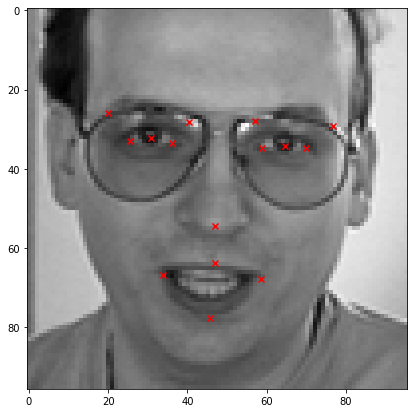

In [404]:
#Original Image in the intial training data
plt.figure(figsize=(7, 7))
plt.imshow(X_train[36].reshape(96,96),cmap='gray')

xs = y_train[36][0::2]
ys = y_train[36][1::2]
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

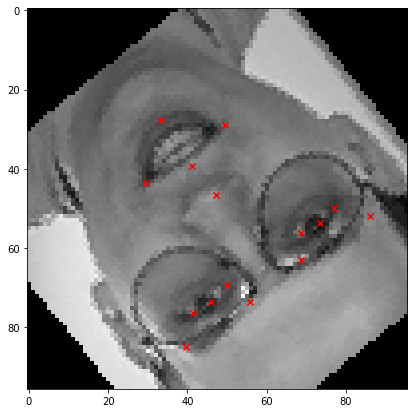

In [405]:
#Transformed image from the original image with landmarks transformed along with the image
#Test for new affine transformed images
#Checking whether landmarks are properly applied for the transformed images
plt.figure(figsize=(7, 7))
plt.imshow(X_train[2099].reshape(96,96),cmap='gray')

xs = y_train[2099][0::2]
ys = y_train[2099][1::2]
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

In [406]:
def get_model():
  model_input = keras.Input((96, 96, 1))
  res_net = layers.ZeroPadding2D((3, 3))(model_input)

  res_net = layers.Conv2D(filters=64, kernel_size=7, strides=2, name='convBlock1')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm1')(res_net)
  res_net = layers.ReLU()(res_net)
  res_net = layers.MaxPool2D(pool_size=3, strides=2)(res_net)


  # FIRST RES BLOCK 
  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=64, kernel_size=1, strides=1, name ='resBlock2ConvA')(res_net)
  # res_net = layers.MaxPool2D(pool_size=2)(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm2ConvA')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', name ='resBlock2ConvB')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm2ConvB')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', name ='resBlock2ConvC')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm2ConvC')(res_net)

  res_net_copy1 = layers.Conv2D(256, kernel_size=1, strides=1, name='resBlock2Copy')(res_net_copy1)
  res_net_copy1 = layers.BatchNormalization(axis=3, name='batchNorm2Copy')(res_net_copy1)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=64, kernel_size=1, strides=1, name ='resBlock2IdentityConv1A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm2IdentityConv1A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', name ='resBlock2IdentityConv1B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm2IdentityConv1B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', name ='resBlock2IdentityConv1C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm2IdentityConv1C')(res_net)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=64, kernel_size=1, strides=1, name ='resBlock2IdentityConv2A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm2IdentityConv2A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', name ='resBlock2IdentityConv2B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm2IdentityConv2B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', name ='resBlock2IdentityConv2C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm2IdentityConv2C')(res_net)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)


  # SECOND RES BLOCK
  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=128, kernel_size=1, strides=1, name ='resBlock3ConvA')(res_net)
  # res_net = layers.MaxPool2D(pool_size=2)(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3ConvA')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', name ='resBlock3ConvB')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3ConvB')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', name ='resBlock3ConvC')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3ConvC')(res_net)

  res_net_copy1 = layers.Conv2D(512, kernel_size=1, strides=1, name='resBlock3Copy')(res_net_copy1)
  res_net_copy1 = layers.BatchNormalization(axis=3, name='batchNorm3Copy')(res_net_copy1)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=128, kernel_size=1, strides=1, name ='resBlock3IdentityConv1A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3IdentityConv1A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', name ='resBlock3IdentityConv1B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3IdentityConv1B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', name ='resBlock3IdentityConv1C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3IdentityConv1C')(res_net)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=128, kernel_size=1, strides=1, name ='resBlock3IdentityConv2A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3IdentityConv2A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', name ='resBlock3IdentityConv2B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3IdentityConv2B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', name ='resBlock3IdentityConv2C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3IdentityConv2C')(res_net)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=128, kernel_size=1, strides=1, name ='resBlock3IdentityConv3A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3IdentityConv3A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', name ='resBlock3IdentityConv3B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3IdentityConv3B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', name ='resBlock3IdentityConv3C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm3IdentityConv3C')(res_net)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=256, kernel_size=1, strides=2, name ='resBlock4ConvA')(res_net)
  # res_net = layers.MaxPool2D(pool_size=2)(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4ConvA')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', name ='resBlock4ConvB')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4ConvB')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=1024, kernel_size=1, strides=1, padding='same', name ='resBlock4ConvC')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4ConvC')(res_net)

  res_net_copy1 = layers.Conv2D(1024, kernel_size=1, strides=2, name='resBlock4Copy')(res_net_copy1)
  res_net_copy1 = layers.BatchNormalization(axis=3, name='batchNorm4Copy')(res_net_copy1)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=256, kernel_size=1, strides=1, name ='resBlock4IdentityConv4A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv4A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', name ='resBlock4IdentityConv4B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv4B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=1024, kernel_size=1, strides=1, padding='same', name ='resBlock4IdentityConv4C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv4C')(res_net)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=256, kernel_size=1, strides=1, name ='resBlock4IdentityConv5A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv5A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', name ='resBlock4IdentityConv5B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv5B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=1024, kernel_size=1, strides=1, padding='same', name ='resBlock4IdentityConv5C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv5C')(res_net)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=256, kernel_size=1, strides=1, name ='resBlock4IdentityConv6A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv6A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', name ='resBlock4IdentityConv6B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv6B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=1024, kernel_size=1, strides=1, padding='same', name ='resBlock4IdentityConv6C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv6C')(res_net)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=256, kernel_size=1, strides=1, name ='resBlock4IdentityConv7A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv7A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', name ='resBlock4IdentityConv7B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv7B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=1024, kernel_size=1, strides=1, padding='same', name ='resBlock4IdentityConv7C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv7C')(res_net)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=256, kernel_size=1, strides=1, name ='resBlock4IdentityConv8A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv8A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', name ='resBlock4IdentityConv8B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv8B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=1024, kernel_size=1, strides=1, padding='same', name ='resBlock4IdentityConv8C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm4IdentityConv8C')(res_net)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=512, kernel_size=1, strides=2, name ='resBlock5ConvA')(res_net)
  # res_net = layers.MaxPool2D(pool_size=2)(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm5ConvA')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', name ='resBlock5ConvB')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm5ConvB')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=2048, kernel_size=1, strides=1, padding='same', name ='resBlock5ConvC')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm5ConvC')(res_net)

  res_net_copy1 = layers.Conv2D(2048, kernel_size=1, strides=2, name='resBlock5Copy')(res_net_copy1)
  res_net_copy1 = layers.BatchNormalization(axis=3, name='batchNorm5Copy')(res_net_copy1)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=512, kernel_size=1, strides=1, name ='resBlock5IdentityConv9A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm5IdentityConv9A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', name ='resBlock5IdentityConv9B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm5IdentityConv9B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=2048, kernel_size=1, strides=1, padding='same', name ='resBlock5IdentityConv9C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm5IdentityConv9C')(res_net)

  res_net = layers.Add()([res_net, res_net_copy1])
  res_net = layers.ReLU()(res_net)

  res_net_copy1 = res_net

  res_net = layers.Conv2D(filters=512, kernel_size=1, strides=1, name ='resBlock5IdentityConv10A')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm5IdentityConv10A')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', name ='resBlock5IdentityConv10B')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm5IdentityConv10B')(res_net)
  res_net = layers.ReLU()(res_net)

  res_net = layers.Conv2D(filters=2048, kernel_size=1, strides=1, padding='same', name ='resBlock5IdentityConv10C')(res_net)
  res_net = layers.BatchNormalization(axis=3, name='batchNorm5IdentityConv10C')(res_net)

  res_net = layers.AveragePooling2D(pool_size=2, name='AveragePooling')(res_net)
  res_net = layers.Flatten()(res_net)


  res_net = layers.Dense(512)(res_net)
  res_net = layers.ReLU()(res_net)
  #res_net = layers.Dropout(0.2)(res_net)


  res_net = layers.Dense(30)(res_net)
  res_net = layers.ReLU()(res_net)

  res_net_model = Model(model_input, res_net)
  print(res_net_model.summary())
  return res_net_model



In [407]:
res_net50 = get_model()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 102, 102, 1)  0          ['input_9[0][0]']                
 D)                                                                                               
                                                                                                  
 convBlock1 (Conv2D)            (None, 48, 48, 64)   3200        ['zero_padding2d_8[0][0]']       
                                                                                                  
 batchNorm1 (BatchNormalization  (None, 48, 48, 64)  256         ['convBlock1[0][0]']       

## Start Training

In [408]:
# import os 
# os.environ['TF_KERAS'] = '1'

# adam = tensorflow.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
# save the best model with least validation loss

def run_model(pretrained=True):
  if pretrained == False:
    res_net50.compile(loss = "mean_squared_error", optimizer = 'adam', metrics = ['accuracy', 'mse'])
    checkpoint = ModelCheckpoint(filepath = "Best_weights.hdf5", save_best_only=True)
    # Train the model
    history = res_net50.fit(X_train, y_train, epochs=250, batch_size=100, validation_split=0.05, callbacks=[checkpoint])
  else:
    return

In [409]:
run_model(pretrained)

## Affine Transformations 

### Setting up Images & Landmarks 

In [410]:
#for using images without scaling them down
def im_setup(img_path, width, height):
    im = cv2.imread(img_path, -1)
    (h, w) = im.shape[:2]
    im = cv2.resize(im, (width,height), interpolation = cv2.INTER_AREA)
    im_uint8 = ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) * 255)).astype('uint8')
    RGB_im = cv2.cvtColor(im_uint8, cv2.COLOR_BGR2RGBA)
    return RGB_im

#for using images without scaling them down
def im_setup2(img_path, width, height):
    im = cv2.imread(img_path, -1)
    (h, w) = im.shape[:2]
    im = cv2.resize(im, (width,height), interpolation = cv2.INTER_AREA)
    im_uint8 = ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) * 255)).astype('uint8')
    gray_im = cv2.cvtColor(im_uint8, cv2.COLOR_BGR2GRAY)
    return gray_im

In [411]:
def createLandMarks(img_type, width,height):
    #landmarks, to be hard set on certain filters
    landmarks = []
    mark_vals = []
    if(img_type == 'nose'):
        #nose 
        landmarks.append((width//2,height *.4))
        
        #left lip
        landmarks.append((.25 * width,height* .7))
        
        #right lip 
        landmarks.append((width - .25 * width ,height* .7 ))
        
        mark_vals = [10,11,12]
        #upper lip
        #xs.append(width//2 )
        #ys.append(height* .7 )
    elif(img_type == 'glasses'):
        #left brow
        landmarks.append((width * .15 ,height * .25 ))
        
        #right brow
        landmarks.append((width * .85 ,height * .25 ))
        
        #nose
        landmarks.append((width * .5 ,height ))
        
        mark_vals = [7,9,10]
    elif(img_type == 'eyes'):
        #left brow
        landmarks.append((width * .05 ,height *.2 ))
        
        #outer eye left
        landmarks.append((width * .1 ,height *.63 ))
        
        #inner eye left
        landmarks.append((width * .36 ,height *.63 ))
        
        #inner eye right
        landmarks.append((width * .64 ,height *.63 ))
        
        #outer eye right 
        landmarks.append((width * .9 ,height *.63 ))
        
        #right brow
        landmarks.append((width * .95 ,height *.2 ))
    
        mark_vals = [7,3,0,1,5,9]
    elif(img_type == 'mouth'):
        
        #left lip
        landmarks.append((width * .05 ,height *.35 ))
        
        #nose
        landmarks.append((width * .5 ,height *.02 ))
        
        #lower lip
        landmarks.append((width * .5 ,height *.67 ))
        
        #right lip
        landmarks.append((width * .95 ,height *.35 ))
        
        mark_vals = [11,10,14,12]
        
    elif(img_type == 'mhat'):
        
        #left brow
        landmarks.append((width * .2 ,height *.75 ))
        
        #nose
        landmarks.append((width * .5 ,height ))
        
        #right brow
        landmarks.append((width * .8 ,height *.75))
        
        mark_vals = [7,10,9]
        
    elif(img_type == 'beard'):
        
        #left outer lip
        landmarks.append((width * .35 ,height *.44 ))
        
        #nose
        landmarks.append((width * .49 ,height *.27 ))
        
        #lower lip
        landmarks.append((width * .49 ,height *.5 ))
        
        #right outer lip
        landmarks.append((width * .65 ,height *.44))
        
        mark_vals = [11,10,14,12]
        
    elif(img_type == 'blush'):
        
        #left brow
        landmarks.append((width * .05 ,height *.0 ))
        
        #nose
        landmarks.append((width * .5 ,height *.67))
        
        #right brow
        landmarks.append((width * .95 ,height *.0))
        
        mark_vals = [7,10,9]
    
    elif(img_type == 'squid'):
        
        #left inner eye
        landmarks.append((width * .3 ,height *.4 ))
        
        #nose
        landmarks.append((width * .5 ,height *.95))
        
        #right inner eye
        landmarks.append((width * .7 ,height *.4))
        
        mark_vals = [2,13,4]
        
    elif(img_type == 'clown'):
        
        #left inner eye
        landmarks.append((width * .25 ,height *0 ))
        
        #nose
        landmarks.append((width * .55 ,height *.5))
        
        #right inner eye
        landmarks.append((width * .85 ,height * 0))
        
        mark_vals = [2,10,4]
        
        
    return landmarks,mark_vals

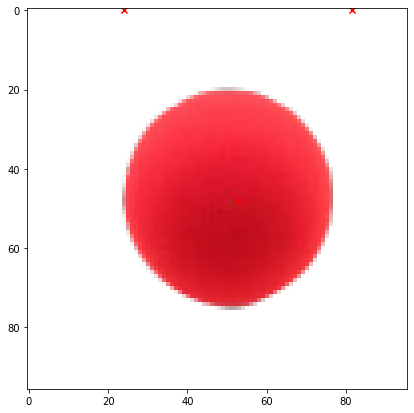

In [412]:
filter_img = im_setup('./CV_Snap_Filter/Filter_Images/clown_nose.png', 96,96)
lm,mv = createLandMarks('clown',96,96)
xs =[]
ys = []

for val in lm:
    xs.append(val[0])
    ys.append(val[1])
    
plt.figure(figsize=(7, 7))
plt.scatter(xs, ys, marker='x', color='red')
plt.imshow(filter_img)

plt.show()

## Creating Our Own Affine Transformations Function and Trying it Out

In [413]:
#take in two sets of 3 points and figure out the affine matrix
class InvalidArraySizes(Exception):
    pass
def affine_transform_mat(sor,dest):
    #errors that could be defined 
    outMat = [[0,0,0],[0,0,0]]
    b = []
    A = []
    try:
        if(len(sor) != len(dest)): #c1 and c2 must have the same amount of points
            raise InvalidArraySizes('There must be the same amount of points in both arrays')
        if(len(sor) < 3):
            raise InvalidArraySizes('source array must have a size of 3 or more')
        if(len(dest) < 3):
            raise InvalidArraySizes('destination array must have a size of 3 or more')
    except InvalidArraySizes as e: 
        print("Error",e)
        return 0
    #setup matricies for Least Squares Error
    for i in range(0, len(sor)):
        #set up b
        b.append([dest[i][0]])
        b.append([dest[i][1]])
        
        #we can assume sor and dest have the same number of points, so set up A here as well
        #format: [xi,yi,1,0,0,0], [0,0,0,xi,yi,1]
        A.append([sor[i][0],sor[i][1],1,0,0,0])
        A.append([0,0,0,sor[i][0],sor[i][1],1])
    b_np = np.array(b)
    A_np = np.array(A)
    #Least Likely Square Equation
    #Equation: affine vars = (A^t * A)^-1 * A^t  * B
    
    A_trans = np.transpose(A_np)
    inter = np.matmul(A_trans,A_np)
    inverse = np.linalg.inv(inter)
    final = np.matmul(np.matmul(inverse,A_trans),b_np).reshape(2,3)
    
    
    
    return final

## Putting Affine Transformation & Overlay Together

In [414]:
#A function that takes in original image, the facial landmarks of the original image,
#and the type of filter to create a new image with the filters overlaying the landmarks

#FORMAT OF FUNCTION: INPUT: face_image converted to RGBA format, 
#landmarks in an array with x,y tuples ex: [(x1,y1),(x2,y2)...(xn,yn)]
#filter type is an int ranging from 0-4
def SCFilterOverlay(face_img, face_lm, filter_type):
    #variables 
    filter_lm = []
    filter_img = []
    
    face_lm_ind = []
    important_face_lm = []
    
    face_width, face_height = face_img.shape[:2]
    filter_width,filter_height = 0,0
    
    final_img = face_img.copy()
    
    
    if(filter_type == 0): #nose
        filter_img = im_setup('./CV_Snap_Filter/Filter_Images/Luigi_Stache.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('nose',filter_width, filter_height)
    
    elif(filter_type == 1): #glasses
        filter_img = im_setup('./CV_Snap_Filter/Filter_Images/HP_Glasses.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('glasses',filter_width, filter_height)
    
    elif(filter_type == 2): #eyes
        filter_img = im_setup('./CV_Snap_Filter/Filter_Images/Eyes.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('eyes',filter_width, filter_height)
    
    elif(filter_type == 3): #mouth
        filter_img = im_setup('./CV_Snap_Filter/Filter_Images/Binky.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('mouth',filter_width, filter_height)
    
    elif(filter_type == 4): #hat
        filter_img = im_setup('./CV_Snap_Filter/Filter_Images/Mario_Hat.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('mhat',filter_width, filter_height)
        
    elif(filter_type == 5): #beard
        filter_img = im_setup('./CV_Snap_Filter/Filter_Images/beard.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('beard',filter_width, filter_height)
        
    elif(filter_type == 6): #blush
        filter_img = im_setup('./CV_Snap_Filter/Filter_Images/Blush.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('blush',filter_width, filter_height)
    
    elif(filter_type == 7): #squid
        filter_img = im_setup('./CV_Snap_Filter/Filter_Images/squidward_nose.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('squid',filter_width, filter_height)
        
    elif(filter_type == 8): #clown
        filter_img = im_setup('./CV_Snap_Filter/Filter_Images/clown_nose.png', face_width,face_height)
        filter_width,filter_height = filter_img.shape[:2]
        filter_lm,face_lm_ind = createLandMarks('clown',filter_width, filter_height)
        
    #fill in important face landmarks array using array
    
    for ind in face_lm_ind:
        important_face_lm.append( (face_lm[ind][0],face_lm[ind][1]) ) 
    
    #find affine transformation of two landmarks
    trans_mat = affine_transform_mat(filter_lm,important_face_lm)
    
    #warp filter image
    new_filt_img = cv2.warpAffine(filter_img, trans_mat, (face_width,face_height))
    
    #overlay image
    # normalize alpha channels
    background = final_img[:,:,3] / 255.0
    foreground = new_filt_img[:,:,3] / 255.0
        
    # set adjusted colors
    for color in range(0, 3):
        final_img[:,:,color] = foreground * new_filt_img[:,:,color] + \
        background * final_img[:,:,color] * (1 - foreground)
    # set adjusted alpha and denormalize back to 0-255
    final_img[:,:,3] = (1 - (1 - foreground) * (1 - background)) * 255
        
    
    return final_img

## Testing out SCFilterOverlay() Function

# Show Filter on Image


In [415]:
def get_predictions(image, model_path='./Best_weights.hdf5'):
  img = im_setup2(image, 96, 96)
  test_new = img.reshape(-1, 96, 96, 1)

  model_best = tf.keras.models.load_model(model_path)
  test_pred = model_best.predict(test_new)

  return test_new, test_pred

In [416]:
### CHANGE VARIABLES IN THIS CELL ###

#filter var
filter = 0
#IF YOU WANT TO ADD MORE FILTERS, YOU MUST CREATE MORE FILTER VARIABLES
filter1 = 6

#model path
model_path = './Best_weights.hdf5'

#filter image path
test_img_path = './CV_Snap_Filter/Test_Images/Caitlyn.png'



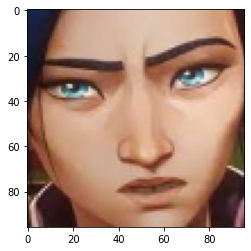

In [417]:
#Set up image & show original face img
test_img = im_setup(test_img_path, 96,96)
plt.imshow(test_img)

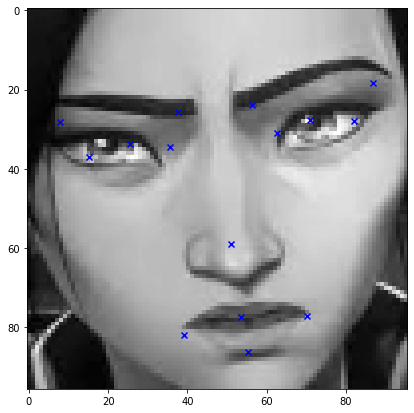

In [418]:

img, pred = get_predictions(test_img_path,model_path)
plt.figure(figsize=(7,7))

plt.imshow(img[0].reshape(96,96),cmap='gray')
xs = pred[0][0::2]
ys = pred[0][1::2]
plt.scatter(xs, ys, marker='x', color='blue')

plt.show()

In [419]:
lm = []
for i in range(0, len(xs)):
  lm.append((xs[i],ys[i]))

new_im = SCFilterOverlay(test_img,lm,filter)
new_im2 = SCFilterOverlay(new_im,lm,filter1)

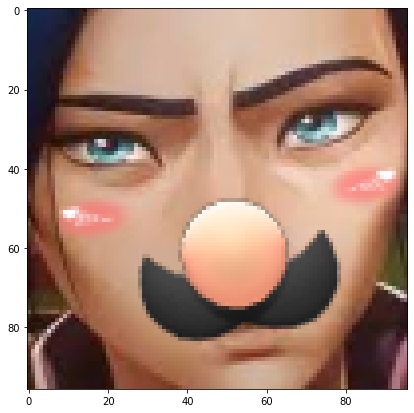

In [420]:
plt.figure(figsize=(7, 7))
plt.imshow(new_im2)